### Spaceship Titanic with fastai

Competition [Link](https://www.kaggle.com/competitions/spaceship-titanic/overview)

In [1]:
#|default_exp app

In [2]:
#The Following cell of code is used everytime FASTAI library is used.
#They tell the notebook to reload any changes made to any libraries used.
#They also ensure that any graphs are plotted are shown in this notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.tabular.all import *
from fastbook import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

import seaborn as sns

from dtreeviz.trees import *
import dtreeviz

from IPython.display import Image, display_svg, SVG

In [4]:
#| export
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
creds = ''

In [5]:
#| export
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [6]:
#| export
path = Path('spaceship-titanic')

In [7]:
#| export
if not iskaggle and not path.exists():
    import zipfile, kaggle
    kaggle.api.competition_download_cli(str(path))    
    zipfile.ZipFile(f'{path}.zip').extractall(path)

In [8]:
#| export
if iskaggle:
    path = Path('../input/spaceship-titanic')
    ! pip install -q dataset

Import CSV's as Pandas Dataframes

In [9]:
#| export
df = pd.read_csv(path/'train.csv', low_memory=False)
test_df = pd.read_csv(path/'test.csv', low_memory=False)
sample_df = pd.read_csv(path/'sample_submission.csv', low_memory=False)

In [10]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [11]:
len(df)

8693

In [12]:
test_df.shape

(4277, 13)

In [13]:
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


This name on such a small dataset could cause overfitting, so I'm going to try splitting into families by last name. I'll also be dropping `Name` as a category afterward

In [14]:
df['surname'] = df['Name'].str.split(' ').str[1]

In [15]:
test_df['surname'] = test_df['Name'].str.split(' ').str[1]

In [16]:
df = df.drop(['Name'], axis=1)

In [17]:
test_df = test_df.drop(['Name'], axis=1)

Looking at this there's some extra data we can extract to new columns, *PassengerId* looks like it's by group number and the number in a particular group, split with an underscore `_` 

In [18]:
df['group_num'] = df['PassengerId'].str.split('_').str[0]
df['num_w_in_group'] = df['PassengerId'].str.split('_').str[1]

In [19]:
test_df['group_num'] =test_df['PassengerId'].str.split('_').str[0]
test_df['num_w_in_group'] =test_df['PassengerId'].str.split('_').str[1]

The same is true for the Cabin, there are 3 different values to analyze here, so let's split them up as well

In [20]:
df['deck'] = df['Cabin'].str.split('/').str[0]
df['room_num'] = df['Cabin'].str.split('/').str[1]
df['side'] = df['Cabin'].str.split('/').str[2]

In [21]:
test_df['deck'] = test_df['Cabin'].str.split('/').str[0]
test_df['room_num'] = test_df['Cabin'].str.split('/').str[1]
test_df['side'] = test_df['Cabin'].str.split('/').str[2]

In [22]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,surname,group_num,num_w_in_group,deck,room_num,side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,Ofracculy,0001,01,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,Vines,0002,01,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,Susent,0003,01,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,Susent,0003,02,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,Santantines,0004,01,F,1,S


In [23]:
df.shape

(8693, 19)

In [24]:
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,surname,group_num,num_w_in_group,deck,room_num,side
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Carsoning,0013,01,G,3,S
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Peckers,0018,01,F,4,S
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Unhearfus,0019,01,C,0,S
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Caltilter,0021,01,C,1,S
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Harperez,0023,01,F,5,S


Take the max number of the last two digits in PassengerId given that the first four numbers are the same

In [25]:
df['num_w_in_group'] = df['num_w_in_group'].astype(int)

In [26]:
test_df['num_w_in_group'] = test_df['num_w_in_group'].astype(int)

In [27]:
max_num_in_group = df.groupby('group_num')['num_w_in_group'].max().astype(int)

In [28]:
test_max_num_in_group = test_df.groupby('group_num')['num_w_in_group'].max().astype(int)

In [29]:
len(max_num_in_group)

6217

In [30]:
max_num_in_group.head()

group_num
0001    1
0002    1
0003    2
0004    1
0005    1
Name: num_w_in_group, dtype: int64

In [31]:
df['num_in_group'] = df['group_num'].map(max_num_in_group)

In [32]:
test_df['num_in_group'] = test_df['group_num'].map(test_max_num_in_group)

In [33]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,surname,group_num,num_w_in_group,deck,room_num,side,num_in_group
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,Ofracculy,0001,1,B,0,P,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,Vines,0002,1,F,0,S,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,Susent,0003,1,A,0,S,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,Susent,0003,2,A,0,S,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,Santantines,0004,1,F,1,S,1


Finding if everyone boarding is a family group or not by last name:
- Find if the count of family group == num_in_group

In [34]:
boarded_together = df.groupby('surname')['num_in_group'].nunique() == 1

In [35]:
test_boarded_together = test_df.groupby('surname')['num_in_group'].nunique() == 1

In [36]:
df['fam_board_together'] = df['surname'].map(boarded_together)

In [37]:
test_df['fam_board_together'] = test_df['surname'].map(test_boarded_together)

In [38]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,surname,group_num,num_w_in_group,deck,room_num,side,num_in_group,fam_board_together
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,Ofracculy,0001,1,B,0,P,1,True
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,Vines,0002,1,F,0,S,1,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,Susent,0003,1,A,0,S,2,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,Susent,0003,2,A,0,S,2,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,Santantines,0004,1,F,1,S,1,False


In [39]:
df.shape

(8693, 21)

In [40]:
test_df.shape

(4277, 20)

In [41]:
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,surname,group_num,num_w_in_group,deck,room_num,side,num_in_group,fam_board_together
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Carsoning,0013,1,G,3,S,1,False
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Peckers,0018,1,F,4,S,1,True
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Unhearfus,0019,1,C,0,S,1,True
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Caltilter,0021,1,C,1,S,1,True
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Harperez,0023,1,F,5,S,1,True


In [42]:
def get_null_counts(df):
    null_count_df = pd.DataFrame((df.isnull().sum()).sort_values(ascending=False).reset_index())
    null_count_df.columns = ['column_name','null_counts']
    null_count_df = null_count_df.query("column_name!='Transported'")
    return null_count_df

null_= get_null_counts(df)
null_.style.background_gradient(cmap='summer')

,column_name,null_counts
0,CryoSleep,217
1,ShoppingMall,208
2,VIP,203
3,HomePlanet,201
4,fam_board_together,200
5,surname,200
6,Cabin,199
7,side,199
8,room_num,199
9,deck,199


In [43]:
test_null = get_null_counts(test_df)
null_.style.background_gradient(cmap='winter')

,column_name,null_counts
0,CryoSleep,217
1,ShoppingMall,208
2,VIP,203
3,HomePlanet,201
4,fam_board_together,200
5,surname,200
6,Cabin,199
7,side,199
8,room_num,199
9,deck,199


Boolean values converted to 0's and 1's

In [44]:
def bool_switch(df, col_name):
    encoder = LabelEncoder()
    df[f'{col_name}'] = encoder.fit_transform(df[f'{col_name}']) 

In [45]:
bool_switch(df, col_name='Transported')
bool_switch(df, col_name='VIP')
bool_switch(df, col_name='CryoSleep')
bool_switch(df, col_name="fam_board_together")

In [46]:
df.shape

(8693, 21)

In [47]:
bool_switch(test_df, col_name='VIP')
bool_switch(test_df, col_name='CryoSleep')
bool_switch(test_df, col_name="fam_board_together")

In [48]:
test_df.shape

(4277, 20)

### Preparing Data

Declare dependant variable(y-axis)

In [49]:
#| export
dep_var = 'Transported'

In [50]:
df['Destination'].sample

<bound method NDFrame.sample of 0         TRAPPIST-1e
1         TRAPPIST-1e
2         TRAPPIST-1e
3         TRAPPIST-1e
4         TRAPPIST-1e
            ...      
8688      55 Cancri e
8689    PSO J318.5-22
8690      TRAPPIST-1e
8691      55 Cancri e
8692      TRAPPIST-1e
Name: Destination, Length: 8693, dtype: object>

Add tabular processes to transform categorical variables to something similar to `pd.Categorical`, and fill in missing/na values

In [51]:
#| export
procs = [Categorify, FillMissing, Normalize]

In [52]:
#| export
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

In [53]:
test_cont, test_cat = cont_cat_split(test_df, 1, dep_var=dep_var)

In [54]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, 
                    y_block=CategoryBlock(), 
                    splits=RandomSplitter(valid_pct=0.2, seed=42)(df)).dataloaders(bs=128)

In [55]:
test_to = TabularPandas(test_df, procs, test_cat, test_cont, y_names=None, 
                    y_block=CategoryBlock(), 
                    splits=None).dataloaders(bs=128)

In [56]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [57]:
test_xs = test_to.train.xs

In [58]:
xs.head()

,PassengerId,HomePlanet,Cabin,Destination,surname,group_num,deck,room_num,side,Age_na,RoomService_na,FoodCourt_na,ShoppingMall_na,Spa_na,VRDeck_na,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,num_w_in_group,num_in_group,fam_board_together
8388,8389,3,3242,3,300,6005,6,786,2,1,1,1,1,1,1,-0.749109,1.612332,-0.206029,1.470626,-0.282769,-0.267182,-0.267988,-0.263122,-0.493406,-0.652869,1.123458
1917,1918,1,5560,3,0,1362,7,1078,1,1,1,1,1,1,1,1.095811,-0.265485,-0.206029,-0.327109,-0.284032,-0.280746,-0.267988,-0.263122,1.383858,2.463179,2.994542
5173,5174,1,6379,2,1504,3719,7,1692,1,1,1,1,1,1,1,-0.749109,0.012710,-0.206029,-0.327109,-0.284032,-0.246835,-0.267988,0.100366,-0.493406,-0.652869,1.123458
8246,8247,1,2091,2,870,5905,5,1351,2,1,1,1,1,1,1,-0.749109,2.377369,-0.206029,-0.327109,-0.284032,-0.145103,-0.267988,1.836428,-0.493406,-0.652869,1.123458
61,62,1,4563,2,1186,44,7,3,2,1,1,1,1,1,1,1.095811,-2.004205,-0.206029,-0.327109,-0.284032,-0.280746,-0.267988,-0.263122,-0.493406,0.593550,-0.747627


In [59]:
xs.shape

(6955, 26)

In [60]:
test_xs.head()

,PassengerId,HomePlanet,Cabin,Destination,surname,group_num,deck,room_num,side,Age_na,RoomService_na,FoodCourt_na,ShoppingMall_na,Spa_na,VRDeck_na,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,num_w_in_group,num_in_group,fam_board_together
0,1,1,2785,3,276,1,7,821,2,1,1,1,1,1,1,1.116736,-0.114147,-0.191678,-0.357339,-0.283840,-0.312173,-0.267841,-0.246712,-0.489847,-0.648973,-1.116345
1,2,1,1868,3,1191,2,6,928,2,1,1,1,1,1,1,-0.758521,-0.684313,-0.191678,-0.357339,-0.277879,-0.312173,2.287504,-0.246712,-0.489847,-0.648973,0.757520
2,3,2,258,1,1605,3,3,1,2,1,1,1,1,1,1,1.116736,0.170937,-0.191678,-0.357339,-0.283840,-0.312173,-0.267841,-0.246712,-0.489847,-0.648973,0.757520
3,4,2,260,3,263,4,3,2,2,1,1,1,1,1,1,-0.758521,0.669832,-0.191678,-0.357339,4.121518,-0.312173,-0.104002,0.226648,-0.489847,-0.648973,0.757520
4,5,1,1941,3,737,5,6,1030,2,1,1,1,1,1,1,-0.758521,-0.613042,-0.191678,-0.340723,-0.283840,0.832122,-0.267841,-0.246712,-0.489847,-0.648973,0.757520


In [61]:
test_xs.shape

(4277, 26)

/tmp/ipykernel_3157/3888966817.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<AxesSubplot: >

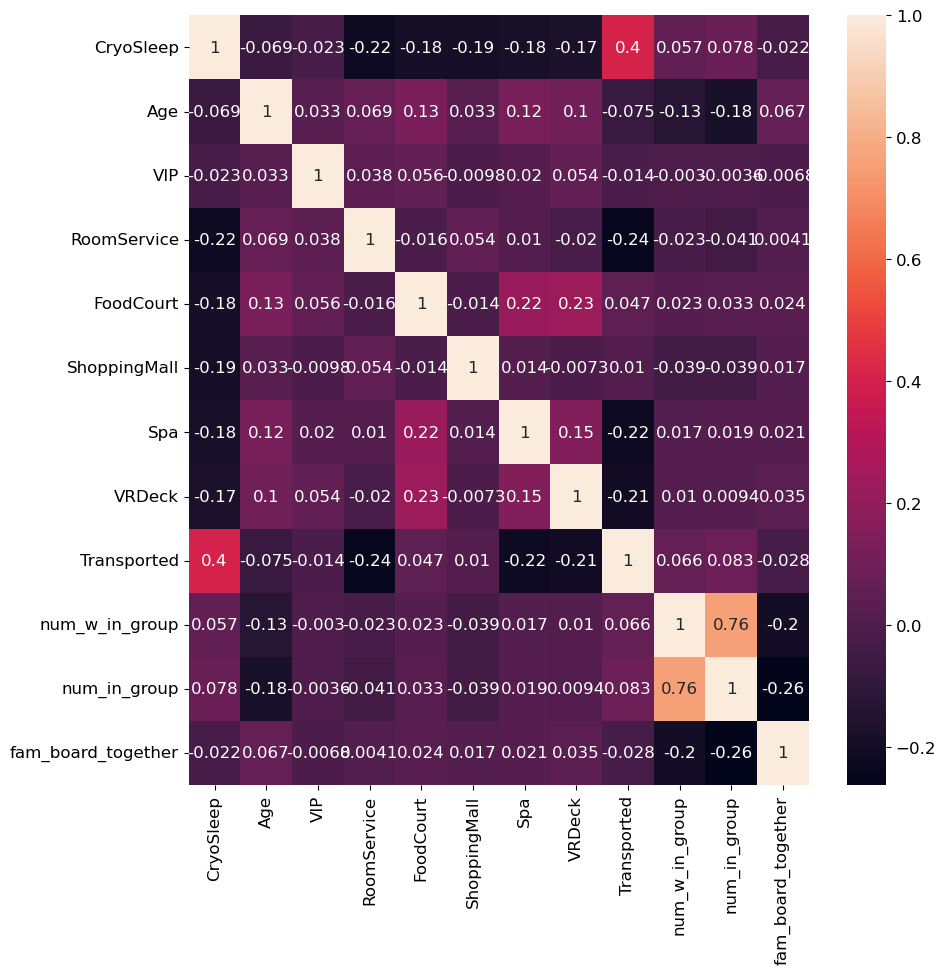

In [62]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True)

In [63]:
def rf(xs, y, n_estimators=40, max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_features=max_features, min_samples_leaf=min_samples_leaf, 
        oob_score=True).fit(xs,y)

In [64]:
m = rf(xs,y)

In [65]:
def pred_acc(m, valid_xs=valid_xs):
    y_pred = m.predict(valid_xs)
    accuracy = accuracy_score(valid_y, y_pred)
    return accuracy

In [66]:
pred_acc(m)

0.8055235903337169

In [67]:
def rf_feat_importances(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

In [68]:
fi = rf_feat_importances(m, xs)
fi

,cols,imp
15,CryoSleep,0.175831
18,RoomService,0.111597
21,Spa,0.093730
22,VRDeck,0.086167
2,Cabin,0.073600
19,FoodCourt,0.070399
16,Age,0.052725
20,ShoppingMall,0.050848
7,room_num,0.046868
4,surname,0.046155


In [69]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

<AxesSubplot: ylabel='cols'>

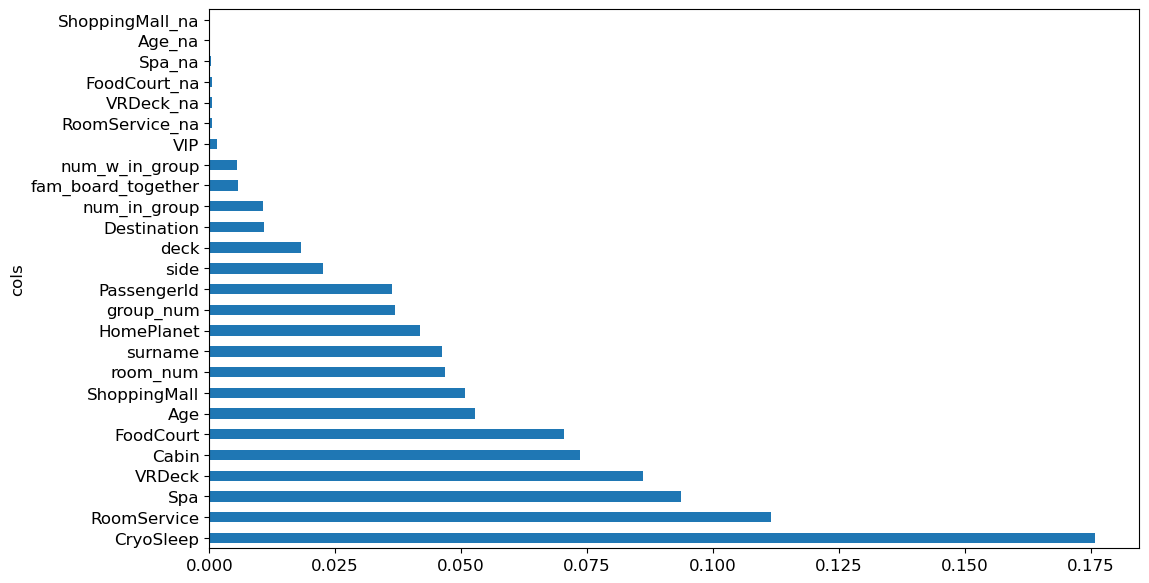

In [70]:
plot_fi(fi)

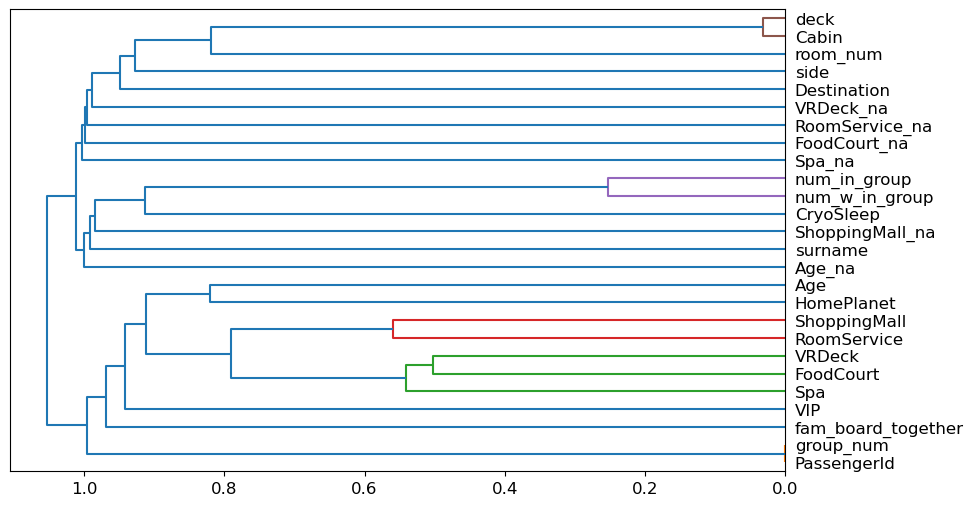

In [71]:
cluster_columns(xs)

In [72]:
to_keep = fi[fi.imp > 0.005].cols
len(to_keep), len(fi)

(19, 26)

In [73]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [74]:
test_xs_imp = test_xs[to_keep]

In [75]:
len(test_xs_imp)

4277

In [76]:
m = rf(xs_imp, y)

In [77]:
pred_acc(m, valid_xs=valid_xs_imp)

0.8095512082853855

<AxesSubplot: ylabel='cols'>

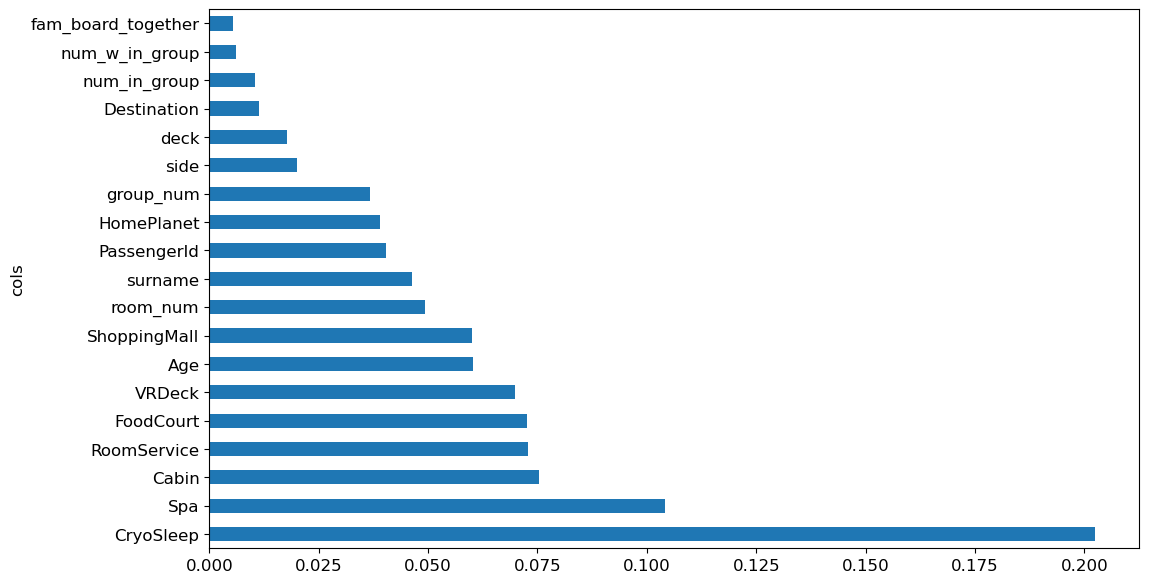

In [78]:
plot_fi(rf_feat_importances(m, xs_imp))

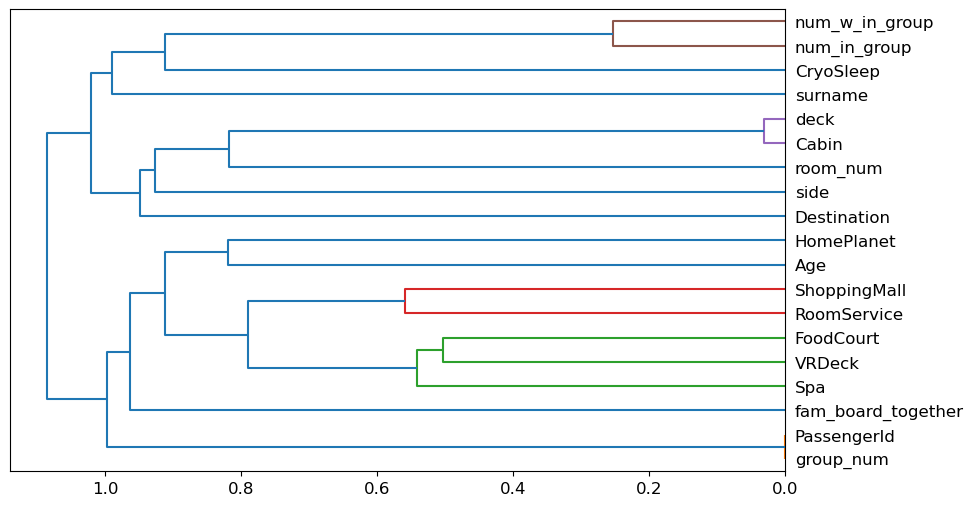

In [79]:
cluster_columns(xs_imp)

In [80]:
def get_oob(df):
    m = RandomForestClassifier(n_estimators=40, min_samples_leaf=15, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [81]:
get_oob(xs_imp)


0.7949676491732567

In [82]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in xs_imp.columns}

{'CryoSleep': 0.7942487419122933,
 'RoomService': 0.7909417685118619,
 'Spa': 0.781020848310568,
 'VRDeck': 0.785765636232926,
 'Cabin': 0.7962616822429907,
 'FoodCourt': 0.7909417685118619,
 'Age': 0.7919482386772106,
 'ShoppingMall': 0.789647735442128,
 'room_num': 0.7951114306254493,
 'surname': 0.800862688713156,
 'HomePlanet': 0.7933860531991374,
 'group_num': 0.7952552120776419,
 'PassengerId': 0.793961179007908,
 'side': 0.7932422717469446,
 'deck': 0.79568655643422,
 'Destination': 0.7945363048166787,
 'num_in_group': 0.7959741193386053,
 'fam_board_together': 0.793098490294752,
 'num_w_in_group': 0.7966930265995686}

In [83]:
{c:get_oob(xs.drop(c, axis=1)) for c in xs.columns}

{'PassengerId': 0.7946800862688713,
 'HomePlanet': 0.7928109273903666,
 'Cabin': 0.7942487419122933,
 'Destination': 0.7968368080517613,
 'surname': 0.79352983465133,
 'group_num': 0.7995686556434219,
 'deck': 0.7979870596693026,
 'room_num': 0.8001437814521927,
 'side': 0.7972681524083394,
 'Age_na': 0.7979870596693026,
 'RoomService_na': 0.793961179007908,
 'FoodCourt_na': 0.7925233644859813,
 'ShoppingMall_na': 0.7932422717469446,
 'Spa_na': 0.7916606757728253,
 'VRDeck_na': 0.792667145938174,
 'CryoSleep': 0.7949676491732567,
 'Age': 0.7942487419122933,
 'VIP': 0.801294033069734,
 'RoomService': 0.7932422717469446,
 'FoodCourt': 0.7928109273903666,
 'ShoppingMall': 0.790079079798706,
 'Spa': 0.7818835370237239,
 'VRDeck': 0.7814521926671459,
 'num_w_in_group': 0.796980589503954,
 'num_in_group': 0.7952552120776419,
 'fam_board_together': 0.7959741193386053}

In [84]:
xs_final = xs_imp
valid_xs_final = valid_xs_imp

In [85]:
test_xs_final = test_xs_imp

In [86]:
xs_final.head()

,CryoSleep,RoomService,Spa,VRDeck,Cabin,FoodCourt,Age,ShoppingMall,room_num,surname,HomePlanet,group_num,PassengerId,side,deck,Destination,num_in_group,fam_board_together,num_w_in_group
8388,-0.749109,1.470626,-0.267988,-0.263122,3242,-0.282769,1.612332,-0.267182,786,300,3,6005,8389,2,6,3,-0.652869,1.123458,-0.493406
1917,1.095811,-0.327109,-0.267988,-0.263122,5560,-0.284032,-0.265485,-0.280746,1078,0,1,1362,1918,1,7,3,2.463179,2.994542,1.383858
5173,-0.749109,-0.327109,-0.267988,0.100366,6379,-0.284032,0.012710,-0.246835,1692,1504,1,3719,5174,1,7,2,-0.652869,1.123458,-0.493406
8246,-0.749109,-0.327109,-0.267988,1.836428,2091,-0.284032,2.377369,-0.145103,1351,870,1,5905,8247,2,5,2,-0.652869,1.123458,-0.493406
61,1.095811,-0.327109,-0.267988,-0.263122,4563,-0.284032,-2.004205,-0.280746,3,1186,1,44,62,2,7,2,0.593550,-0.747627,-0.493406


In [87]:
pred_acc(m, valid_xs=valid_xs_final)

0.8095512082853855

In [88]:
valid_xs_final.columns

Index(['CryoSleep', 'RoomService', 'Spa', 'VRDeck', 'Cabin', 'FoodCourt',
       'Age', 'ShoppingMall', 'room_num', 'surname', 'HomePlanet', 'group_num',
       'PassengerId', 'side', 'deck', 'Destination', 'num_in_group',
       'fam_board_together', 'num_w_in_group'],
      dtype='object')

In [89]:
# test_xs = [test_xs.drop([x], axis=1) for x in test_xs if x not in valid_xs_final]

In [90]:
# for x in test_xs.columns:
#     if x not in valid_xs_final.columns:
#         test_xs = test_xs.drop([x], axis=1)

In [91]:
len(test_xs_final)

4277

In [92]:
len(test_xs.columns), len(valid_xs_final.columns)

(26, 19)

In [93]:
test_xs.columns, valid_xs_final.columns

(Index(['PassengerId', 'HomePlanet', 'Cabin', 'Destination', 'surname',
        'group_num', 'deck', 'room_num', 'side', 'Age_na', 'RoomService_na',
        'FoodCourt_na', 'ShoppingMall_na', 'Spa_na', 'VRDeck_na', 'CryoSleep',
        'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa',
        'VRDeck', 'num_w_in_group', 'num_in_group', 'fam_board_together'],
       dtype='object'),
 Index(['CryoSleep', 'RoomService', 'Spa', 'VRDeck', 'Cabin', 'FoodCourt',
        'Age', 'ShoppingMall', 'room_num', 'surname', 'HomePlanet', 'group_num',
        'PassengerId', 'side', 'deck', 'Destination', 'num_in_group',
        'fam_board_together', 'num_w_in_group'],
       dtype='object'))

In [94]:
preds = m.predict(test_xs_final)

In [95]:
preds

array([1, 0, 1, ..., 1, 1, 1], dtype=int8)

In [96]:
sample_df.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


In [97]:
sample_df['Transported'] = preds.astype(bool)

In [102]:
sample_df.value_counts()

PassengerId  Transported
0013_01      True           1
6288_02      False          1
6269_01      True           1
6269_02      False          1
6269_03      True           1
                           ..
3072_01      True           1
3074_01      True           1
3075_01      True           1
3077_01      True           1
9277_01      True           1
Length: 4277, dtype: int64

In [103]:
sub_df = sample_df

In [107]:
sub_df

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [108]:
sub_df.to_csv('submission.csv', index=False)